In [1]:
import pylab
import nest

## Experiment 1
- 3 HH neurons
- reciprocal delayed synaptic connections
- intracellular constant current stimulation of $10 \frac{\mu A}{cm^2}$
- random inital phase

![alt text](img/exp1.png "Experiment 1")

### Configuration following Materials and Methods SI

$C = 1 \frac{\mu F}{cm^2}$

$g_{Na} = 120 \frac{mS}{cm^2}, g_K = 36 \frac{mS}{cm^2}, g_L = 0.3 \frac{mS}{cm^2}$

$E_{Na} = 50 mV, E_K = -77 mV, E_L = -54.5 mV$

$\tau_r = \tau_{ex} = 0.1 ms, \tau_d = \tau_{in} = 3 ms$

In [2]:
# Init neurons

""" 
hh_pcs_alpha because:
- hh_cond_beta_gap_traub is not a compartment model
- hh_psc_alpha_clopath only has additional fatures
"""
neuron_alpha = nest.Create("hh_psc_alpha")
neuron_beta = nest.Create("hh_psc_alpha")
neuron_gamma = nest.Create("hh_psc_alpha")

In [3]:
# configuration
# intracellular constant current stimulation as external input current 

# TODO: shift phases randomly

nest.SetStatus(neuron_alpha, 
               {
                   "C_m": 1000000.0, 
                   "g_Na": 120000.0, 
                   "g_K": 36000.0,
                   "g_L": 300.0,
                   "E_Na": 50.0,
                   "E_K": -77.0,
                   "E_L": -54.5,
                   "tau_syn_ex": 0.1,
                   "tau_syn_in": 3.0,
                   "I_e": 10000000.0
               })
nest.SetStatus(neuron_beta, 
               {
                   "C_m": 1000000.0, 
                   "g_Na": 120000.0, 
                   "g_K": 36000.0,
                   "g_L": 300.0,
                   "E_Na": 50.0,
                   "E_K": -77.0,
                   "E_L": -54.5,
                   "tau_syn_ex": 0.1,
                   "tau_syn_in": 3.0,
                   "I_e": 10000000.0
               })
nest.SetStatus(neuron_gamma, 
               {
                   "C_m": 1000000.0, 
                   "g_Na": 120000.0, 
                   "g_K": 36000.0,
                   "g_L": 300.0,
                   "E_Na": 50.0,
                   "E_K": -77.0,
                   "E_L": -54.5,
                   "tau_syn_ex": 0.1,
                   "tau_syn_in": 3.0
               })

In [4]:
# connect neurons reciprocally
syn_dict = {"weight": 1.0, "delay": 1.0}
nest.Connect(neuron_alpha, neuron_gamma, syn_spec=syn_dict)
nest.Connect(neuron_beta, neuron_gamma, syn_spec=syn_dict)
nest.Connect(neuron_gamma, neuron_alpha, syn_spec=syn_dict)
nest.Connect(neuron_gamma, neuron_beta, syn_spec=syn_dict)

In [5]:
# devices

# multimeter
multimeter_alpha = nest.Create("multimeter")
multimeter_beta = nest.Create("multimeter")
multimeter_gamma = nest.Create("multimeter")

nest.SetStatus(multimeter_alpha, {"record_from":["V_m"]})
nest.SetStatus(multimeter_beta, {"record_from":["V_m"]})
nest.SetStatus(multimeter_gamma, {"record_from":["V_m"]})

nest.Connect(multimeter_alpha, neuron_alpha)
nest.Connect(multimeter_beta, neuron_beta)
nest.Connect(multimeter_gamma, neuron_gamma)

# spike detectors
spikedetector_alpha = nest.Create("spike_detector")
spikedetector_beta = nest.Create("spike_detector")
spikedetector_gamma = nest.Create("spike_detector")

nest.Connect(neuron_alpha, spikedetector_alpha)
nest.Connect(neuron_beta, spikedetector_alpha)
nest.Connect(neuron_gamma, spikedetector_alpha)

In [6]:
# simulate
nest.Simulate(1000.0)

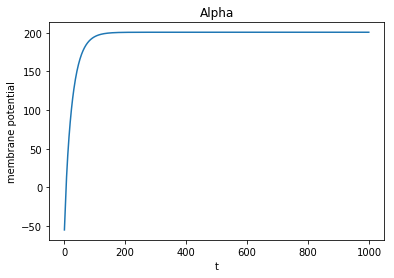

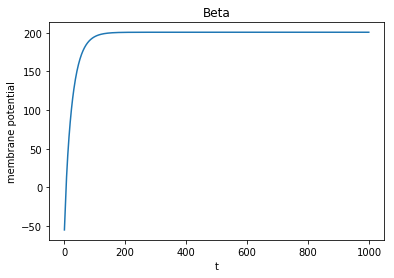

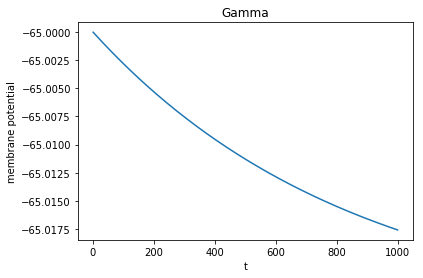

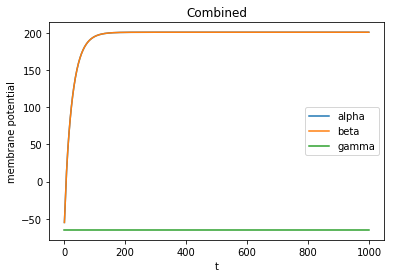

In [7]:
# plot membrane potential
dmm_alpha = nest.GetStatus(multimeter_alpha)[0]
Vms_alpha = dmm_alpha["events"]["V_m"]
ts_alpha = dmm_alpha["events"]["times"]

dmm_beta = nest.GetStatus(multimeter_beta)[0]
Vms_beta = dmm_beta["events"]["V_m"]
ts_beta = dmm_beta["events"]["times"]

dmm_gamma = nest.GetStatus(multimeter_gamma)[0]
Vms_gamma = dmm_gamma["events"]["V_m"]
ts_gamma = dmm_gamma["events"]["times"]

pylab.figure(1)
pylab.plot(ts_alpha, Vms_alpha)
pylab.xlabel("t")
pylab.ylabel("membrane potential")
pylab.title("Alpha")
pylab.show()

pylab.figure(2)
pylab.plot(ts_beta, Vms_beta)
pylab.xlabel("t")
pylab.ylabel("membrane potential")
pylab.title("Beta")
pylab.show()

pylab.figure(3)
pylab.plot(ts_gamma, Vms_gamma)
pylab.xlabel("t")
pylab.ylabel("membrane potential")
pylab.title("Gamma")
pylab.show()

pylab.figure(4)
pylab.plot(ts_alpha, Vms_alpha)
pylab.plot(ts_beta, Vms_beta)
pylab.plot(ts_gamma, Vms_gamma)
pylab.legend(["alpha", "beta", "gamma"])
pylab.xlabel("t")
pylab.ylabel("membrane potential")
pylab.title("Combined")
pylab.show()

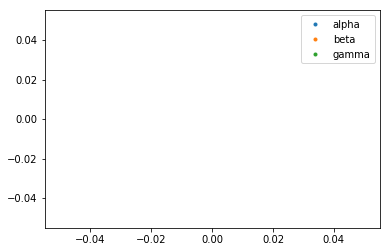

In [8]:
# plot occurrances
dSD_alpha = nest.GetStatus(spikedetector_alpha, keys="events")[0]
evs_alpha = dSD_alpha["senders"]
ts_sd_alpha = dSD_alpha["times"]

dSD_beta = nest.GetStatus(spikedetector_beta, keys="events")[0]
evs_beta = dSD_beta["senders"]
ts_sd_beta = dSD_beta["times"]

dSD_gamma = nest.GetStatus(spikedetector_gamma, keys="events")[0]
evs_gamma = dSD_gamma["senders"]
ts_sd_gamma = dSD_gamma["times"]

pylab.figure(2)
pylab.plot(ts_sd_alpha, evs_alpha, ".")
pylab.plot(ts_sd_beta, evs_beta, ".")
pylab.plot(ts_sd_gamma, evs_gamma, ".")
pylab.legend(["alpha", "beta", "gamma"])
pylab.show()